In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../lib')
from meep_nb import *

import meep as mp
from meep import mpb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
num_bands = 10
k_points = [mp.Vector3(),          # Gamma
            mp.Vector3(0.5),]       # X
#             mp.Vector3(0.5, 0.5),  # M
#             mp.Vector3()]          # Gamma
k_points = mp.interpolate(4, k_points)

In [201]:
w1 = .3
w2 = .4
pitch = .7
duty = .5
thickness = 1e12

# from meep.materials import Si as Si, SiO2 as oxide
Si = mp.Medium(epsilon=1)
oxide = mp.Medium(epsilon=1)

l1 = pitch*duty
l2 = pitch * (1 - duty)
geometry = [
            mp.Block(mp.Vector3(l1, w1, thickness), center=mp.Vector3(-pitch/2+l1/2, 0, 0), material=Si),
            mp.Block(mp.Vector3(l2, w2, thickness), center=mp.Vector3(pitch/2-l2/2, 0, 0), material=Si),
           ] # height is infinite
geometry_lattice = mp.Lattice(size=mp.Vector3(pitch, 2))
resolution = 32

In [202]:
ms = mpb.ModeSolver(num_bands=num_bands,
                    k_points=k_points,
                    geometry=geometry,
                    default_material=oxide,
                    geometry_lattice=geometry_lattice,
                    resolution=resolution)

In [203]:
# Run it
ms.run_tm(mpb.fix_efield_phase)
tm_freqs = ms.all_freqs
tm_gaps = ms.gap_list

ms.run_te(mpb.fix_hfield_phase)
te_freqs = ms.all_freqs
te_gaps = ms.gap_list

Initializing eigensolver data
Computing 10 bands with 1e-07 tolerance
6 k-points
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.1, 0.0, 0.0>
  Vector3<0.2, 0.0, 0.0>
  Vector3<0.30000000000000004, 0.0, 0.0>
  Vector3<0.4, 0.0, 0.0>
  Vector3<0.5, 0.0, 0.0>
elapsed time for initialization: 0.002256155014038086
elapsed time for k point: 0.1004629135131836
elapsed time for k point: 0.7051601409912109
elapsed time for k point: 0.013795852661132812
elapsed time for k point: 0.01181173324584961
elapsed time for k point: 0.009293079376220703
elapsed time for k point: 0.40938806533813477
Band 1 range: 0.0 at Vector3<0.0, 0.0, 0.0> to 0.7142857142857143 at Vector3<0.5, 0.0, 0.0>
Band 2 range: 0.5000000070446602 at Vector3<0.0, 0.0, 0.0> to 0.7592961594350984 at Vector3<0.4, 0.0, 0.0>
Band 3 range: 0.500000008250374 at Vector3<0.0, 0.0, 0.0> to 0.8718968297243418 at Vector3<0.5, 0.0, 0.0>
Band 4 range: 0.8571428768783431 at Vector3<0.4, 0.0, 0.0> to 1.0400157013427094 at Vector3<0.2, 0.0, 0.0>
Band 5 rang

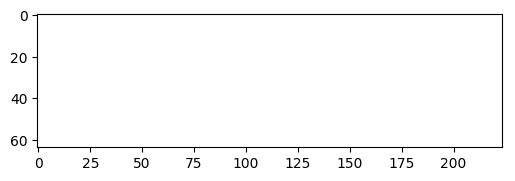

In [204]:
# Visualize index structure
converted_eps = show_geometry(ms, x=10, y=1)

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


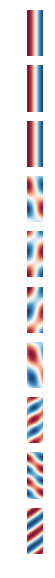

In [206]:
# Plot fields
md = mpb.MPBData(rectify=True, x=1, y=1, resolution=32)

fi, ax = plt.subplots(nrows=num_bands, ncols=1, figsize=(5, 10))
for iBand in range(num_bands):
# for iBand in [6, 7]:
    axRow = ax[iBand]
    plt.sca(axRow)
#     eps = ms.get_efield(which_band=iBand, bloch_phase=False) # for TM
    eps = ms.get_hfield(which_band=iBand, bloch_phase=False, )
    eps_data = md.convert(eps)
    scalar_data = np.real(eps_data[:, :, 2])
        
    plt.contour(converted_eps.T, cmap='binary', linewidths=1)
    vrange = max(abs(np.max(scalar_data)), abs(np.min(scalar_data)))
    plt.imshow(scalar_data.transpose()[::-1], interpolation='spline36', cmap='RdBu_r',
               alpha=0.9, vmin=-vrange, vmax=vrange)
    plt.axis('off')
#         plt.title('iBand={}, axis={}'.format(iBand, ['x', 'y', 'z'][iDim%3]))

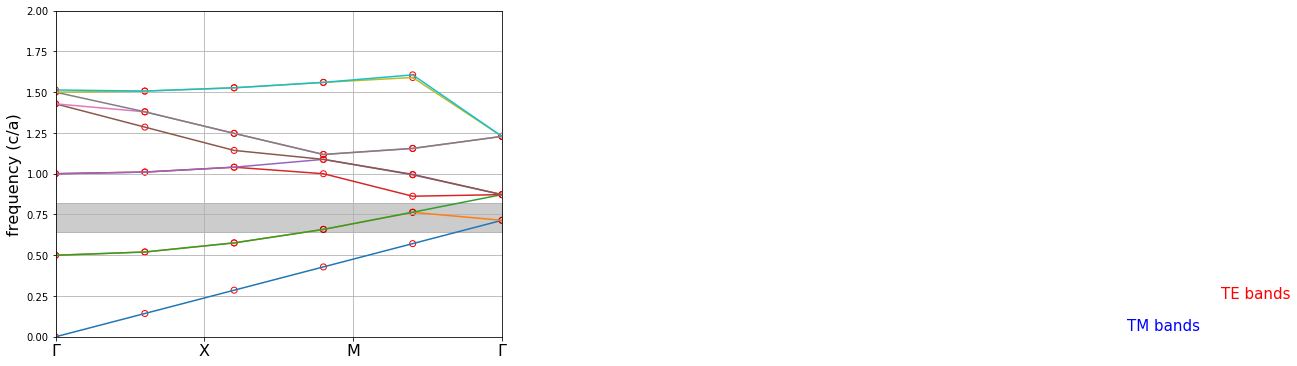

In [207]:
fig, ax = plt.subplots(figsize=(8,6))
# te_freqs = te_freqs[6:8]
x = range(len(tm_freqs))
# Plot bands
# Scatter plot for multiple y values, see https://stackoverflow.com/a/34280815/2261298
for xz, tmz, tez in zip(x, tm_freqs, te_freqs):
#     ax.scatter([xz]*len(tmz), tmz, color='blue')
    ax.scatter([xz]*len(tez), tez, color='red', facecolors='none')
# ax.plot(tm_freqs, color='blue')
ax.plot(te_freqs[:,:])#, color='red')
ax.set_ylim([0, 2])
ax.set_xlim([x[0], x[-1]])

# Plot gaps
for gap in tm_gaps:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='blue', alpha=0.2)

for gap in te_gaps:
    if gap[0] > 1:
        ax.fill_between(x, gap[1], gap[2], color='red', alpha=0.2)
        
# 1220 to 1550
ax.fill_between(x, .64, .82, color='k', alpha=0.2)


# Plot labels
ax.text(12, 0.04, 'TM bands', color='blue', size=15)
ax.text(13.05, 0.235, 'TE bands', color='red', size=15)

points_in_between = (len(tm_freqs) - 4) / 3
tick_locs = [i*points_in_between+i for i in range(4)]
tick_labs = ['Γ', 'X', 'M', 'Γ']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labs, size=16)
ax.set_ylabel('frequency (c/a)', size=16)
ax.grid(True)

In [57]:
def lam2freq(lam):
    return 1e-6 / lam

In [154]:
1e-6/1.55e-6
# te_freqs

0.6451612903225806